In [1]:
#ignore warnings
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

import tensorflow as tf
# data generator 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# wandb
import wandb
from wandb.keras import WandbCallback

DATA_PATH = '/kaggle/input/fashion-product-images-dataset/'

%matplotlib inline

# Exploratory and Visualizations

## Images Dataframe

In [2]:
images_df = pd.read_csv(
    os.path.join(DATA_PATH, 'fashion-dataset', 'images.csv')
)

In [3]:
images_df.head(2)

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...


## Product Meta Data Dataframe

In [ ]:
image

In [4]:
styles_df = pd.read_csv(
    os.path.join(DATA_PATH, 'fashion-dataset', 'styles.csv'),
    on_bad_lines='skip'
)

In [5]:
styles_df.head(2)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans


## Create Unique ID in both Dataframes

In [6]:
images_df.head(2)

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...


In [7]:
# tạo id để merge với metadata df
images_df['id'] = images_df['filename']\
.apply(lambda filename: filename\
       .replace('.jpg', '')).astype(int)

In [8]:
images_df.head(2)

,filename,link,id
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...,15970
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...,39386


## Merging the two dataframes

In [9]:
data = styles_df.merge(images_df, on='id', how='left')
data.head(2)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,http://assets.myntassets.com/v1/images/style/p...


In [10]:
# chuyển filename thành filepath
data['filename'] = data['filename']\
.apply(lambda filename: os.path.join(DATA_PATH, 'fashion-dataset', 'images', filename))
data.head(2)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...


## Removing Products for which images are not present

In [11]:
# lấy danh sách ảnh trong dataset
image_files = os.listdir(
    os.path.join(DATA_PATH, 'fashion-dataset', 'images')
)
print(len(image_files))

44441


In [12]:
# các file có trong dataset
data['file_found'] = data['id'].apply(lambda idx: '{}.jpg'.format(idx)  in image_files)

In [13]:
data['file_found'].value_counts()

True     44419
False        5
Name: file_found, dtype: int64

In [14]:
# xóa bỏ file không có ảnh trong dataset
data = data[data['file_found']].reset_index(drop=True)
print(data.shape)
data.head(2)

(44419, 13)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,file_found
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...,True


## Checking for Missing data

In [15]:
data.isnull().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
filename                0
link                    0
file_found              0
dtype: int64

## Visualizations

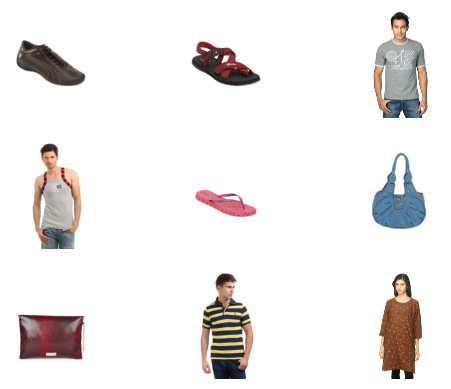

In [16]:
# trực quan một số hình ảnh trong datasets
def dislay_image(image_files):
    random.shuffle(image_files)
    for idx, image_file in enumerate(image_files[0:9]):
        plt.subplot(3, 3, idx+1)
        image_path = os.path.join(DATA_PATH, 'fashion-dataset', 'images', image_file)
        image_arr = cv2.imread(image_path)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image_arr)
        plt.axis("off")

dislay_image(image_files) 

In [17]:
# masterCategory count 
gr_data_masterCate = data.groupby('masterCategory').size()
gr_data_masterCate_sorted= gr_data_masterCate.sort_values()
gr_data_masterCate_sorted

masterCategory
Home                  1
Sporting Goods       25
Free Items          105
Personal Care      2403
Footwear           9219
Accessories       11274
Apparel           21392
dtype: int64

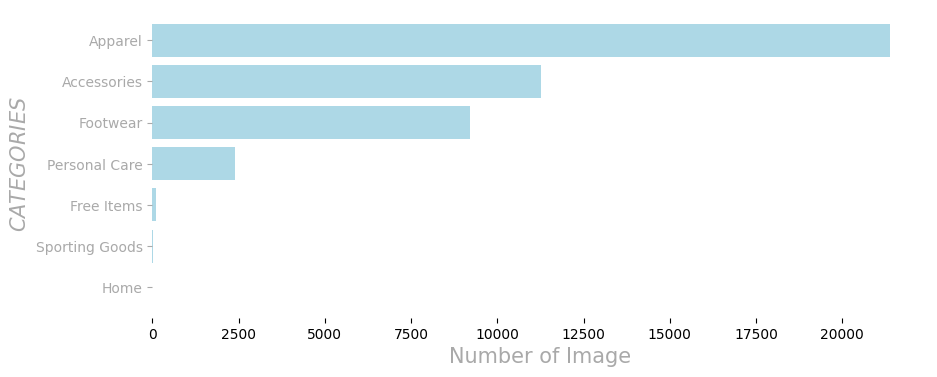

In [18]:
plt.figure(figsize = (10, 4))
with plt.rc_context({"ytick.color":"darkgrey"}):
    plt.barh(gr_data_masterCate_sorted.index, gr_data_masterCate_sorted.values, color='lightblue')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.ylabel("$CATEGORIES$", size=15, color="darkgrey")
plt.xlabel("Number of Image", size=15, color="darkgrey")
plt.show()

In [19]:
# subCategory count 
gr_data_subCate = data.groupby('subCategory').size()
gr_data_subCate_sorted= gr_data_subCate.sort_values()

In [20]:
len(gr_data_subCate_sorted)

45

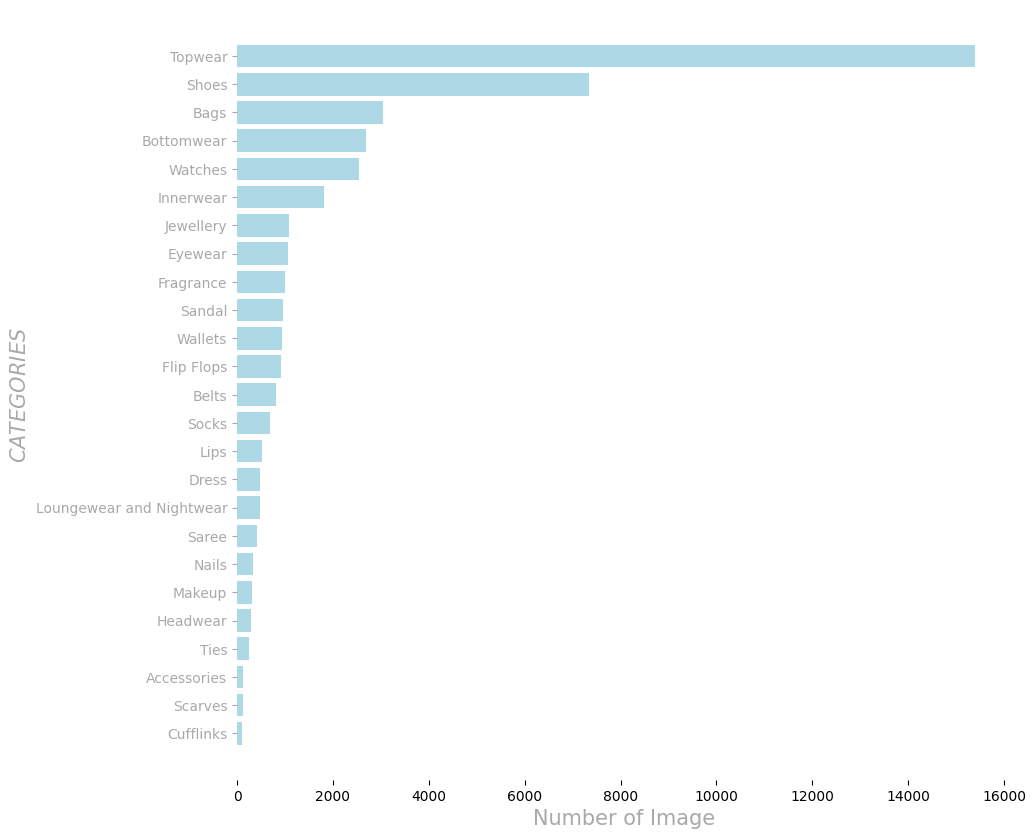

In [21]:
plt.figure(figsize = (10, 10))
with plt.rc_context({"ytick.color":"darkgrey"}):
    plt.barh(gr_data_subCate_sorted[-25:].index, gr_data_subCate_sorted[-25:].values, color='lightblue')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.ylabel("$CATEGORIES$", size=15, color="darkgrey")
plt.xlabel("Number of Image", size=15, color="darkgrey")
plt.show()

In [22]:
# articleType count 
gr_data_articleType = data.groupby('articleType').size()
gr_data_articleType_sorted = gr_data_articleType.sort_values()

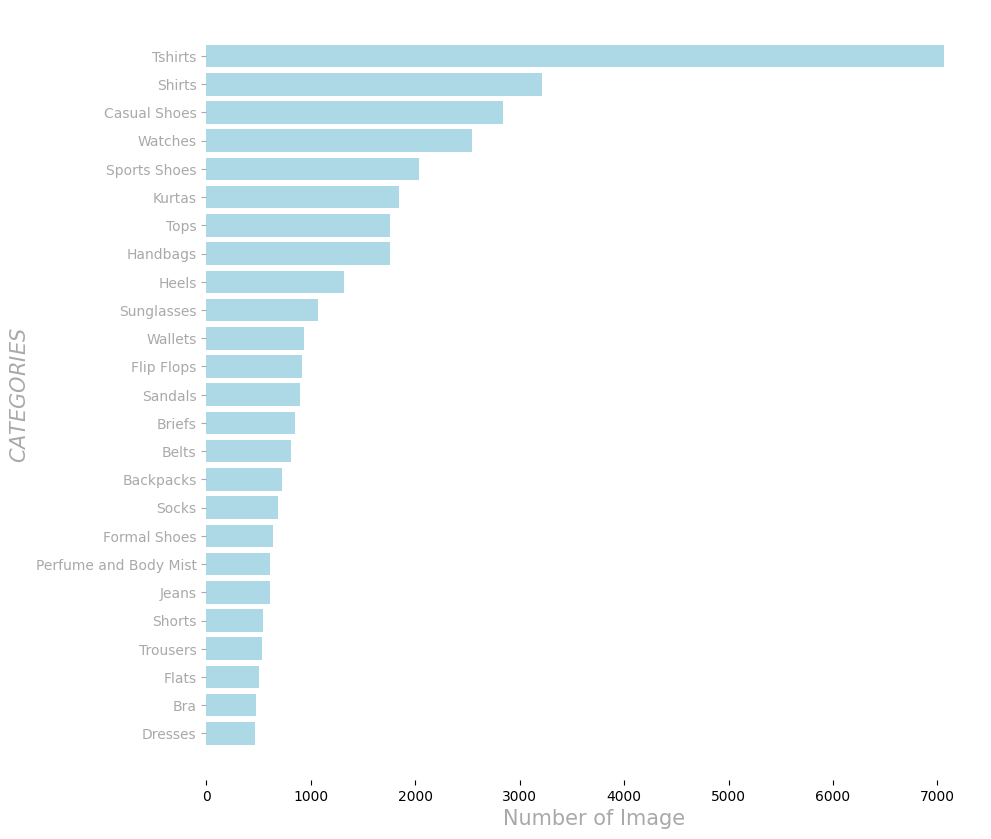

In [23]:
plt.figure(figsize = (10, 10))
with plt.rc_context({"ytick.color":"darkgrey"}):
    plt.barh(gr_data_articleType_sorted[-25:].index, gr_data_articleType_sorted[-25:].values, color='lightblue')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.ylabel("$CATEGORIES$", size=15, color="darkgrey")
plt.xlabel("Number of Image", size=15, color="darkgrey")
plt.show()

## final data

In [24]:
# lấy 20 danh mục 

In [25]:
categoricals = sorted(list(gr_data_subCate_sorted.index[-20:]))

In [26]:
data_20 = data[data['subCategory'].isin(categoricals)]

In [27]:
data_20

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,file_found
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...,True
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...,True
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...,True
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...,True
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44414,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...,True
44415,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...,True
44416,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...,True
44417,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...,True


In [28]:
data_20.drop(['file_found'], axis=1, inplace=True)

In [29]:
data_20

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
...,...,...,...,...,...,...,...,...,...,...,...,...
44414,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
44415,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
44416,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
44417,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...


In [30]:
data_20.duplicated(subset=['id']).sum()

0

In [31]:
data_20.groupby('subCategory').size().sort_values(ascending=False)

subCategory
Topwear                     15398
Shoes                        7343
Bags                         3055
Bottomwear                   2693
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
dtype: int64

In [33]:
categoricals_12 = sorted(list(gr_data_subCate_sorted.index[-12:]))
data_12 = data[data['subCategory'].isin(categoricals)]
data_12.drop(['file_found'], axis=1, inplace=True)
data_12.duplicated(subset=['id']).sum()
data_12.groupby('subCategory').size().sort_values(ascending=False)

subCategory
Topwear                     15398
Shoes                        7343
Bags                         3055
Bottomwear                   2693
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
dtype: int64

In [34]:
# mỗi danh mục lấy tối đa 800 ảnh
# 12 lấy 900


In [35]:
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split

In [37]:
n_samples = 900
lst_df = []
for categorical in categoricals_12:
    df_class_tmp = data_12.loc[data_12['subCategory'] == categorical]
    if df_class_tmp.shape[0] < n_samples:
        df_resample_tmp = df_class_tmp
    else:
        df_resample_tmp = resample(df_class_tmp, n_samples=n_samples, random_state=42)
    lst_df.append(df_resample_tmp)
df = pd.concat(lst_df)

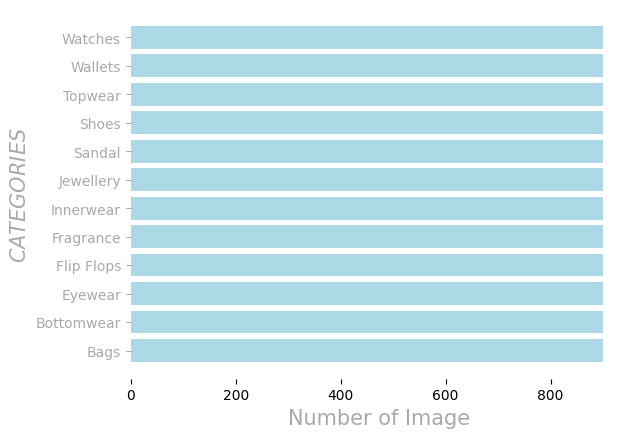

In [38]:
cate = df.groupby('subCategory').size().sort_values()

# plt.figure(figsize = (10, 10))
with plt.rc_context({"ytick.color":"darkgrey"}):
    plt.barh(cate[-25:].index, cate[-25:].values, color='lightblue')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.ylabel("$CATEGORIES$", size=15, color="darkgrey")
plt.xlabel("Number of Image", size=15, color="darkgrey")
plt.show()

In [39]:
df.shape

(10800, 12)

In [40]:
df = shuffle(df, random_state=42)
df = df.reset_index(drop=True)

In [41]:
df

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link
0,27604,Men,Apparel,Bottomwear,Trousers,Khaki,Summer,2012.0,Casual,Scullers Men Khaki Trouser,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
1,14860,Women,Accessories,Wallets,Wallets,Charcoal,Summer,2011.0,Casual,United Colors of Benetton Women Solid Grey Cha...,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
2,38235,Unisex,Accessories,Eyewear,Sunglasses,Brown,Winter,2016.0,Casual,Polaroid Unisex Sunglasses,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
3,30095,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Ed Hardy Men Black and Red Dial Watch,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
4,19629,Men,Apparel,Topwear,Tshirts,White,Summer,2011.0,Casual,United Colors of Benetton Men Printed White TS...,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
...,...,...,...,...,...,...,...,...,...,...,...,...
10795,48609,Women,Accessories,Jewellery,Earrings,Silver,Summer,2013.0,Casual,Lucera Women Silver Earrings,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
10796,53507,Women,Apparel,Innerwear,Bra,Nude,Winter,2015.0,Casual,Amante Nude-Coloured Full-Coverage Bra BFOM12,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/image/style/pr...
10797,50636,Men,Apparel,Innerwear,Innerwear Vests,Grey Melange,Winter,2016.0,Casual,Chromozome Men Grey Melange Innerwear Vest,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...
10798,52647,Women,Accessories,Bags,Handbags,Black,Summer,2012.0,Casual,Mod'acc Women Black Handbag,/kaggle/input/fashion-product-images-dataset/f...,http://assets.myntassets.com/v1/images/style/p...


In [42]:
# luu du lieu da xu ly
file_path = 'fashion-product_12.csv'
df.to_csv(file_path, index=False)

In [40]:
def display_category(list_path):
    for idx, path in enumerate(list_path):
        plt.subplot(3, 3, idx+1)
        image = image_preprocess(path)[0]
        plt.imshow(image)
        plt.axis('off')
    plt.show()

In [41]:
IMAGESIZE = 224
CHANNELS = 3
def image_preprocess(image_path):
    image_orig = cv2.imread(image_path)
    image_arr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
    image_arr = cv2.resize(image_arr, (IMAGESIZE, IMAGESIZE))
    image_arr = image_arr/255.
    image_arr = image_arr.reshape(-1, IMAGESIZE, IMAGESIZE, CHANNELS)
    return image_arr

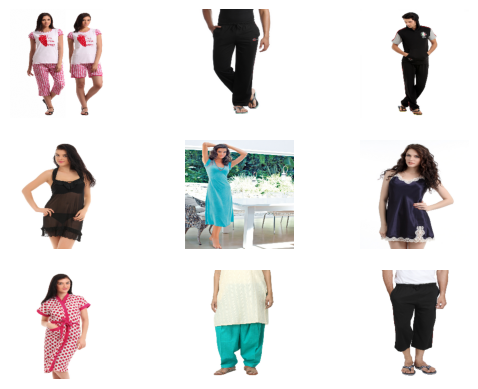

In [42]:
display_category(df[df['subCategory'] == 'Loungewear and Nightwear']['filename'][:9])

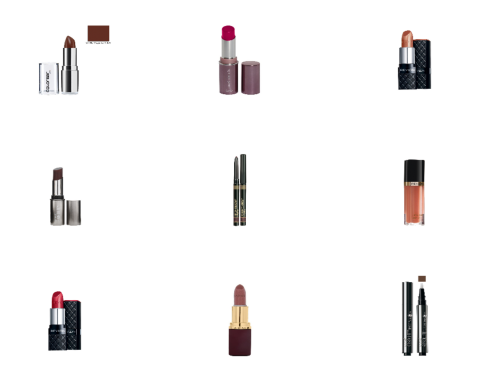

In [43]:
display_category(df[df['subCategory'] == 'Lips']['filename'][:9])

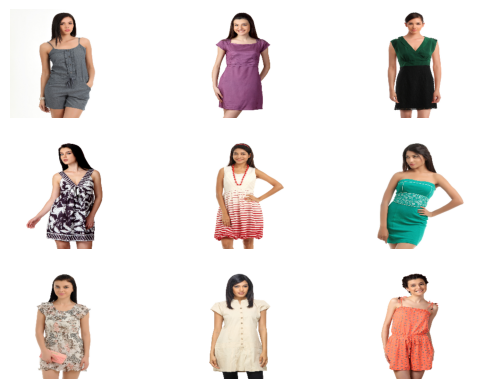

In [44]:
display_category(df[df['subCategory'] == 'Dress']['filename'][:9])

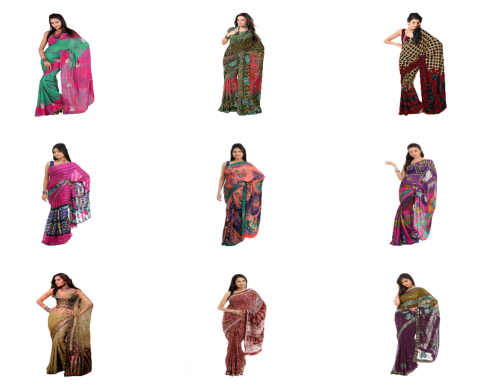

In [45]:
display_category(df[df['subCategory'] == 'Saree']['filename'][:9])

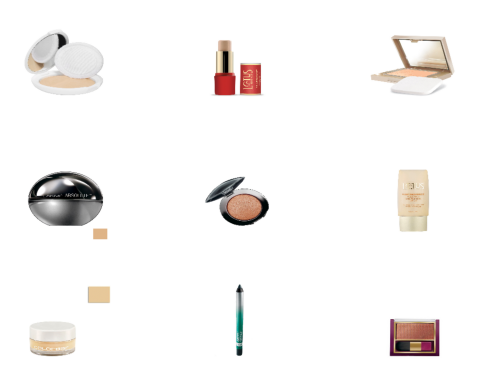

In [46]:
display_category(df[df['subCategory'] == 'Makeup']['filename'][:9])

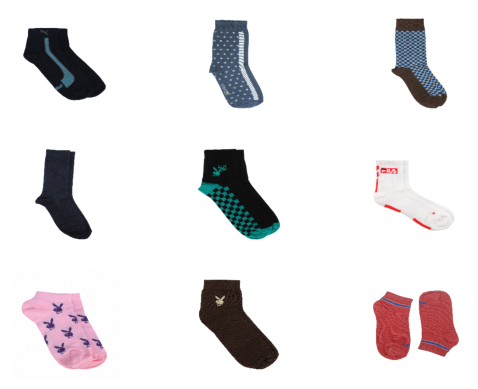

In [47]:
display_category(df[df['subCategory'] == 'Socks']['filename'][:9])

# Train-val-test Split

## Data Augmentation

In [48]:
datagen = ImageDataGenerator(rescale=1/255.,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True)

train_generator = datagen.flow_from_dataframe(dataframe=train_df,
                                             target_size=(224,224),
                                             x_col='filename',
                                            y_col='categorical',
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=True,
                                              seed=42)


test_datagen = ImageDataGenerator(rescale=1/255.)
valid_generator = test_datagen.flow_from_dataframe(dataframe=valid_df,
                                             target_size=(224,224),
                                             x_col='filename',
                                            y_col='categorical',
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=True,
                                              seed=42)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='categorical',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

NameError: name 'train_df' is not defined

In [ ]:
# tmp

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_model(name, weights_path=None):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='leaky_relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='sigmoid')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(20, activation='softmax')(x)

    model = Model(name=name, inputs=base_model.input, outputs=predictions)
    if weights_path:
        model.load_weights(weights_path)
    return model

In [ ]:
NAME = "vgg19-{}".format(int(time.time()))
model = build_model(NAME)
model.summary()

In [ ]:
lr = 0.01
epochs = 10
## Initlisazie wandb project
wandb.init(project='CBIR-fashion product dataset',
           name= NAME,
          config={
              "learning_rate": lr,
              "Batch_normalization": True,
              "Batch_size" : 64,
              "Dropout" : "0.4",
              "architecture": "VGG19",
              "dataset": "fashion-product-images-dataset",
              "epochs": epochs,
              "data generator" : True
          }
          )

In [ ]:
wandb_callback = WandbCallback()

filepath = "{}_loss_opti.hdf5".format(NAME)

checkpoint1 = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch"
)


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr),
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_generator,
                    validation_data = train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=epochs,
                    callbacks=[checkpoint1, wandb_callback])

In [ ]:
# model.save(filepath)

In [ ]:
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model(filepath)

In [ ]:
score = best_model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
IMAGESIZE = 224
CHANNELS = 3
def image_preprocess(image_path):
    image_orig = cv2.imread(image_path)
    image_arr = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
    image_arr = cv2.resize(image_arr, (IMAGESIZE, IMAGESIZE))
    image_arr = image_arr/255.
    image_arr = image_arr.reshape(-1, IMAGESIZE, IMAGESIZE, CHANNELS)
    return image_arr

In [ ]:
test_df.filename[1]

In [ ]:
anchor_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/50892.jpg'
pos_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/45986.jpg'
neg_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/29863.jpg'
image_arr1 = image_preprocess(anchor_path)
image_arr2 = image_preprocess(pos_path)
image_arr3 = image_preprocess(neg_path)
image_lst = [image_arr1, image_arr2, image_arr3]
for i, image_arr in enumerate(image_lst):
    plt.subplot(1, 3, i+1)
    plt.imshow(image_arr[0])
    plt.axis(False)
plt.show()

In [ ]:
y_hat = model.predict(image_arr)

In [ ]:
y_hat.argmax()

In [ ]:
categoricals[14]

In [ ]:
best_model.layers

In [ ]:
CBIR_model = Model(inputs=best_model.input, outputs=best_model.layers[-4].output)

In [ ]:
prehashcode1 = CBIR_model.predict(image_arr1)
prehashcode2 = CBIR_model.predict(image_arr2)
prehashcode3 = CBIR_model.predict(image_arr3)

In [ ]:
prehashcode.shape

In [ ]:
hashcode1 = np.where(prehashcode1<0.5, 0, 1)
hashcode2 = np.where(prehashcode2<0.5, 0, 1)
hashcode3 = np.where(prehashcode3<0.5, 0, 1)

In [ ]:
hashcode1 = hashcode1.astype('bool')
hashcode2 = hashcode2.astype('bool')
hashcode3 = hashcode3.astype('bool')

In [ ]:
hamming_distance = np.hamming(hashcode1.shape[0]) * np.abs(hashcode1 - hashcode2)

In [ ]:
hamming_dist = np.count_nonzero(hashcode1 != hashcode2)

In [ ]:
hamming_dist

In [ ]:
hamming_dist = np.count_nonzero(hashcode1 != hashcode3)
hamming_dist

In [ ]:
hamming_dist = np.count_nonzero(hashcode2 != hashcode3)
hamming_dist